### Imports

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from skimage.util import montage
from IPython.display import Image, display, SVG, clear_output, HTML
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["font.size"] = 8
plt.rcParams["font.family"] = ['sans-serif']
plt.rcParams["font.sans-serif"] = ['DejaVu Sans']
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['image.cmap'] = 'gray'
def draw_graph_mpl(g, pos=None, ax=None, layout_func=nx.drawing.kamada_kawai_layout, draw_labels=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    else:
        fig = None
    if pos is None:
        pos = layout_func(g)
    node_color = []
    node_labels = {}
    shift_pos = {}
    for k in g:
        node_color.append(g.nodes[k].get('color', 'black'))
        node_labels[k] = g.nodes[k].get('label', k)
        shift_pos[k] = [pos[k][0], pos[k][1]]

    edge_color = []
    edge_width = []
    for e in g.edges():
        edge_color.append(g.edges[e].get('color', 'black'))
        edge_width.append(g.edges[e].get('width', 0.5))
    nx.draw_networkx_edges(g, pos, edge_color=edge_color, width=edge_width, alpha=0.5, ax=ax)
    nx.draw_networkx_nodes(g, pos, node_color=node_color, node_shape='s', node_size=20, alpha=0.75, ax=ax)
    if draw_labels:
        nx.draw_networkx_labels(g, shift_pos, labels=node_labels, ax=ax)
    ax.autoscale()
    return fig, ax, pos

In [2]:
import numpy as np
import scipy.sparse as sp
from spektral.data import Dataset, Graph
from tensorflow.keras.datasets import mnist
from sklearn.neighbors import kneighbors_graph

MNIST_SIZE = 28

class MNIST(Dataset):
    def __init__(self, k=8, noise_level=0.0, **kwargs):
        self.a = None
        self.k = k
        self.noise_level = noise_level
        (self.X_train, self.y_train), (self.X_test, self.y_test) = mnist.load_data()
        self.X_train, self.X_test = self.X_train / 255., self.X_test / 255.
        self.X_train = self.X_train.reshape(-1, MNIST_SIZE ** 2)
        self.X_test = self.X_test.reshape(-1, MNIST_SIZE ** 2)
        super().__init__(**kwargs)

    def read(self):
        self.a = _mnist_grid_graph(self.k)
        self.a = _flip_random_edges(self.a, self.noise_level).astype(np.float32)
        x = np.vstack((self.X_train, self.X_test))
        y = np.concatenate((self.y_train, self.y_test), 0)
        return [Graph(x=x_, y=y_) for x_, y_ in zip(x, y)]

def _grid_coordinates(side):
    M = side ** 2
    x = np.linspace(0, 1, side, dtype=np.float32)
    y = np.linspace(0, 1, side, dtype=np.float32)
    xx, yy = np.meshgrid(x, y)
    z = np.empty((M, 2), np.float32)
    z[:, 0] = xx.reshape(M)
    z[:, 1] = yy.reshape(M)
    return z

def _get_adj_from_data(X, k, **kwargs):
    A = kneighbors_graph(X, k, **kwargs).toarray()
    A = sp.csr_matrix(np.maximum(A, A.T))
    return A

def _mnist_grid_graph(k):
    X = _grid_coordinates(MNIST_SIZE)
    A = _get_adj_from_data(X, k, mode='connectivity', metric='euclidean', include_self=False)
    return A

def _flip_random_edges(A, percent):
    if not A.shape[0] == A.shape[1]:
        raise ValueError('A must be a square matrix.')
    dtype = A.dtype
    A = sp.lil_matrix(A).astype(np.bool)
    n_elem = A.shape[0] ** 2
    n_elem_to_flip = round(percent * n_elem)
    unique_idx = np.random.choice(n_elem, replace=False, size=n_elem_to_flip)
    row_idx = unique_idx // A.shape[0]
    col_idx = unique_idx % A.shape[0]
    idxs = np.stack((row_idx, col_idx)).T
    for i in idxs:
        i = tuple(i)
        A[i] = np.logical_not(A[i])
    A = A.tocsr().astype(dtype)
    A.eliminate_zeros()
    return A

### Libraries

In [3]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import sparse_categorical_accuracy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

from spektral.data import MixedLoader
from spektral.utils import normalized_laplacian, flatten_list
from spektral.layers import GCNConv, global_pool, GlobalAvgPool
from spektral.utils.sparse import sp_matrix_to_sp_tensor

In [4]:
# Load data
data = MNIST()

D:\Anaconda\envs\graph-nx\lib\site-packages\ipykernel_launcher.py:68: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
D:\Anaconda\envs\graph-nx\lib\site-packages\spektral\data\graph.py:67: UserWarning: x was automatically reshaped to (784, 1)
  warnings.warn(f"x was automatically reshaped to {x.shape}")


### Label Nodes and Show Connections

In [6]:
xx, yy = np.meshgrid(np.arange(28), np.arange(28))
node_id = ['X:{:02d}_Y:{:02d}'.format(x, y) for x, y in zip(xx.ravel(), yy.ravel())]

print(node_id[500], 'is connected to')
for row, col in zip(*data.a[500].nonzero()):
    print(col, '->', node_id[col])

X:24_Y:17 is connected to
471 -> X:23_Y:16
472 -> X:24_Y:16
473 -> X:25_Y:16
499 -> X:23_Y:17
501 -> X:25_Y:17
527 -> X:23_Y:18
528 -> X:24_Y:18
529 -> X:25_Y:18


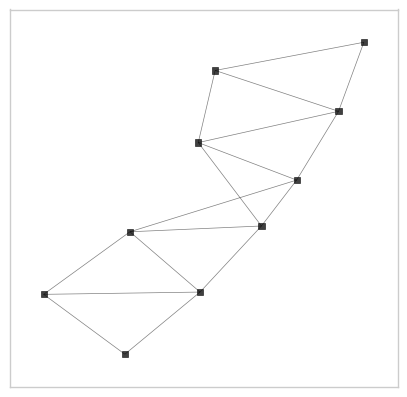

In [7]:
G = nx.from_scipy_sparse_matrix(data.a[:10, :10])
for k, pix_val in zip(G.nodes, data.X_train[19]):
    G.nodes[k]['label'] = node_id[k]
draw_graph_mpl(G);

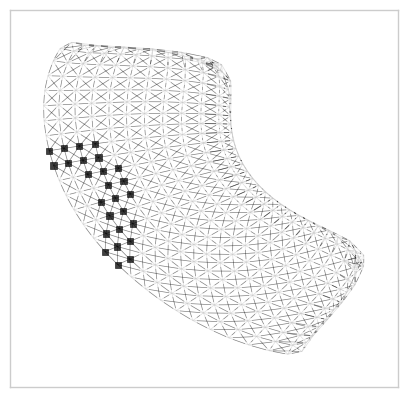

In [8]:
MAX_NODE = 28*12
G = nx.from_scipy_sparse_matrix(data.a[:MAX_NODE, :MAX_NODE])
for k, pix_val in zip(G.nodes, data.X_train[19]):
    G.nodes[k]['label'] = node_id[k]
    G.nodes[k]['color'] = 'black' if pix_val > 0.5 else 'white'
draw_graph_mpl(G);

(<Figure size 500x500 with 1 Axes>,
 <AxesSubplot:>,
 array([[ 0,  0],
        [ 1,  0],
        [ 2,  0],
        ...,
        [25, 27],
        [26, 27],
        [27, 27]]))

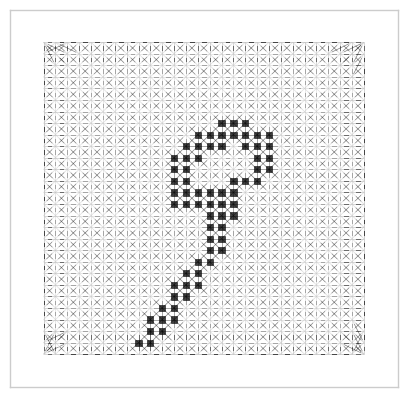

In [9]:
G = nx.from_scipy_sparse_matrix(data.a)
for k, pix_val in zip(G.nodes, data.X_train[19].reshape((MNIST_SIZE, MNIST_SIZE))[::-1,:].flatten()):
    G.nodes[k]['label'] = ''
    G.nodes[k]['color'] = 'black' if pix_val > 0.5 else 'white'
draw_graph_mpl(G, pos=np.stack([xx.ravel(), yy.ravel()], -1))

### Model Building

In [10]:
# Parameters
l2_reg = 5e-4
learning_rate = 1e-3
batch_size = 32
epochs = 10
es_patience = 200

In [11]:
# The adjacency matrix is stored as an attribute of the dataset.
# Create filter for GCN and convert to sparse tensor.
data.a = GCNConv.preprocess(data.a)
data.a = sp_matrix_to_sp_tensor(data.a)

# Train/valid/test split
data_tr, data_te = data[:-10000], data[-10000:]
# np.random.shuffle(data_tr)
data_tr, data_va = data_tr[:-10000], data_tr[-10000:]

loader_tr = MixedLoader(data_tr, batch_size=batch_size, epochs=epochs)
loader_val = MixedLoader(data_va, batch_size=batch_size)
loader_te = MixedLoader(data_te, batch_size=batch_size)

In [12]:
# Build model
class GNN(Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = GCNConv(32, activation='relu', kernel_regularizer=l2(l2_reg))
        self.conv2 = GCNConv(32, activation='relu', kernel_regularizer=l2(l2_reg))
        self.flatten = Flatten()
        self.fc1 = Dense(512, activation="relu")
        self.fc2 = Dense(10, activation="softmax")

    def call(self, inputs, **kwargs):
        x, a = inputs
        x = self.conv1([x, data.a])
        x = self.conv2([x, data.a])
        output = self.flatten(x)
        output = self.fc1(output)
        output = self.fc2(output)

        return output

In [13]:
# Create model
model = GNN()
optimizer = Adam(learning_rate=learning_rate)
loss_fn = SparseCategoricalCrossentropy()

## Training function
@tf.function
def train_on_batch(inputs, target):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(target, predictions) + sum(model.losses)
        acc = tf.reduce_mean(sparse_categorical_accuracy(target, predictions))

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, acc


# Evaluation function
def evaluate(loader):
    step = 0
    results = []
    for batch in loader:
        step += 1
        inputs, target = batch
        predictions = model(inputs, training=False)
        loss = loss_fn(target, predictions)
        acc = tf.reduce_mean(sparse_categorical_accuracy(target, predictions))
        results.append((loss, acc, len(target)))  # Keep track of batch size
        if step == loader.steps_per_epoch:
            results = np.array(results)
            return np.average(results[:, :-1], 0, weights=results[:, -1])

In [14]:
# Setup training
best_val_loss = 99999
current_patience = es_patience
step = 0

# Training loop
results_tr = []
for batch in loader_tr:
    step += 1

    # Training step
    inputs, target = batch
    loss, acc = train_on_batch(inputs, target)
    results_tr.append((loss, acc, len(target)))

    if step == loader_tr.steps_per_epoch:
        results_va = evaluate(loader_val)
        if results_va[0] < best_val_loss:
            best_val_loss = results_va[0]
            current_patience = es_patience
            results_te = evaluate(loader_te)
        else:
            current_patience -= 1
            if current_patience == 0:
                print("Early stopping")
                break

        # Print results
        results_tr = np.array(results_tr)
        results_tr = np.average(results_tr[:, :-1], 0, weights=results_tr[:, -1])
        print(
            "Train loss: {:.4f}, acc: {:.4f} | "
            "Valid loss: {:.4f}, acc: {:.4f} | "
            "Test loss: {:.4f}, acc: {:.4f}".format(
                *results_tr, *results_va, *results_te
            )
        )

        # Reset epoch
        results_tr = []
        step = 0

D:\Anaconda\envs\graph-nx\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MNIST' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Train loss: 0.2570, acc: 0.9228 | Valid loss: 0.1274, acc: 0.9625 | Test loss: 0.1347, acc: 0.9599
Train loss: 0.1272, acc: 0.9628 | Valid loss: 0.1068, acc: 0.9693 | Test loss: 0.1113, acc: 0.9671
Train loss: 0.0963, acc: 0.9705 | Valid loss: 0.0898, acc: 0.9717 | Test loss: 0.0774, acc: 0.9747
Train loss: 0.0766, acc: 0.9769 | Valid loss: 0.0971, acc: 0.9715 | Test loss: 0.0774, acc: 0.9747
Train loss: 0.0641, acc: 0.9803 | Valid loss: 0.0793, acc: 0.9762 | Test loss: 0.0822, acc: 0.9740
Train loss: 0.0546, acc: 0.9833 | Valid loss: 0.0777, acc: 0.9772 | Test loss: 0.0754, acc: 0.9766
Train loss: 0.0461, acc: 0.9861 | Valid loss: 0.0761, acc: 0.9787 | Test loss: 0.0767, acc: 0.9765
Train loss: 0.0407, acc: 0.9878 | Valid loss: 0.0716, acc: 0.9804 | Test loss: 0.0699, acc: 0.9797
Train loss: 0.0342, acc: 0.9899 | Valid loss: 0.0760, acc: 0.9808 | Test loss: 0.0699, acc: 0.9797
Train loss: 0.0306, acc: 0.9909 | Valid loss: 0.0730, acc: 0.9808 | Test loss: 0.0699, acc: 0.9797
